In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# The following is mostly setup for my own preference -- feel free to change to your liking :-)
plt.rcParams['figure.figsize'] = [12, 8]
sns.set(
    style="ticks",
    rc={
        "font.family": "Arial",
        "font.size": 40,
        "axes.linewidth": 2,
        "lines.linewidth": 3,
    },
    font_scale=2.5,
    palette=sns.color_palette("Set2")
)

### Quick info
It's samples of yogurt where the concentration of riboflavin has been measured with excitation and emission spectroscopy. There's is also further information about each sample in the file "info_conditions.csv" and "conditions.csv".
The file "conditions.csv" has the following four extra variables about each sample:
1. Batch no. (0/1)
2. Light (0=Light, 1=darkness)
3. Packaging (0=polylactate, 1=polystyrene)
4. Storage time in days

For more info, please refer to the following paper. This paper should also be cited if you intend to use this dataset for anything serious :-):
    Christensen, J., Miquel Becker, E., and Frederiksen, C.S.
    Fluorescence Spectroscopy and PARAFAC in analysis of yoghurt
    Chemometrics and Intelligent Laboratory 75(2005)201-208

In [13]:
riboflavin = np.genfromtxt("./riboflavin.csv", delimiter=",")  # concentrations of riboflavin
em = np.genfromtxt("./Em.csv", delimiter=",")  # emission axis
ex = np.genfromtxt("./Ex.csv", delimiter=",")  # excitation axis
X = np.genfromtxt("./X.csv", delimiter=",")  # measurements
conditions = np.genfromtxt("./conditions.csv", delimiter=",")

In [15]:
print(f"Values on the emission axis: {em}")
print(f"Values on the excitation axis: {ex}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Values on the emission axis: [310. 330. 350. 370. 390. 410. 430. 450. 470. 490. 510. 530. 550. 570.
 590.]
Values on the excitation axis: [270. 290. 310. 330. 350. 370. 390. 410. 430. 450. 470. 490. 510. 530.
 550.]
Number of samples: 125
Number of features: 225


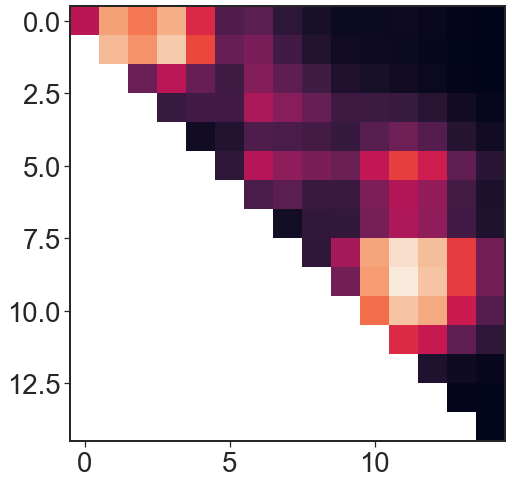

In [4]:
X_2dhists = np.array([x.reshape((15, 15)) for x in X])
plt.imshow(X_2dhists[0])

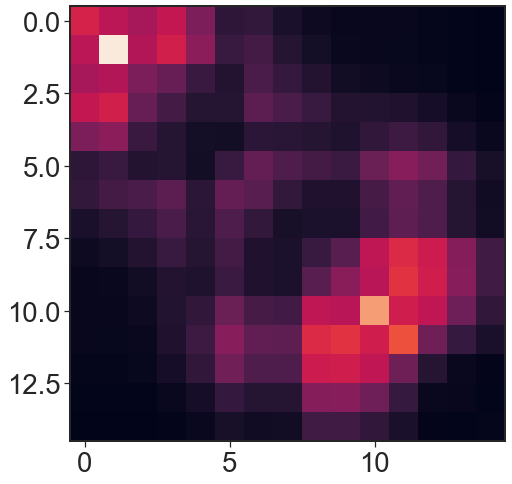

In [5]:
new_X = []

for sample in X_2dhists:
    tmp = np.nan_to_num(sample.copy())
    tmp_diag = np.diag(tmp)

    tmp += tmp.T
    indices = np.arange(len(tmp))
    tmp[indices, indices] = tmp_diag

    new_X.append(tmp)
new_X = np.array(new_X)
plt.imshow(new_X[0])
plt.show()

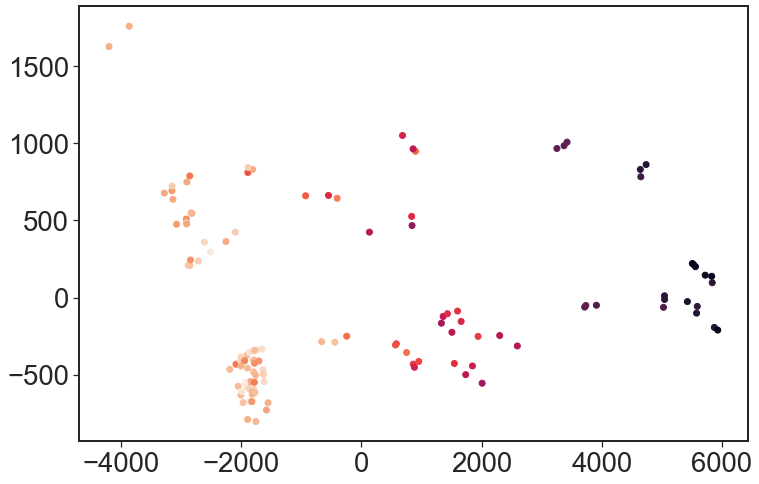

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
new_X = np.array([x.ravel() for x in new_X])  # ravel/flatten to make it nice for PCA
trans = pca.fit_transform(new_X)

plt.scatter(trans[:, 0], trans[:, 1], c=riboflavin)
plt.show()

Naïvely, we remove samples that has a concentration of `nan`. Dealing with `nan`s or missing values is called _imputing_. There are more advances methods than just removing them.

Feel free to explore more advances methods!

In [7]:
no_nan_riboflavin = riboflavin[~np.isnan(riboflavin)]
X = new_X[~np.isnan(riboflavin)]

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, no_nan_riboflavin, test_size=0.3, random_state=42)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()
rfe = RFE(estimator=LinearRegression(), n_features_to_select=3, step=1)

In [10]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, no_nan_riboflavin, scoring='neg_mean_squared_error', cv=10)
print(f"CV RMSE w/o FS: {cv_results['test_score'].mean()*-1:.4}")

cv_results = cross_validate(rfe, X, no_nan_riboflavin, scoring='neg_mean_squared_error', cv=10)
print(f"CV RMSE w. FS: {cv_results['test_score'].mean()*-1:.4}")

CV RMSE w/o FS: 0.1533
CV RMSE w. FS: 0.0601


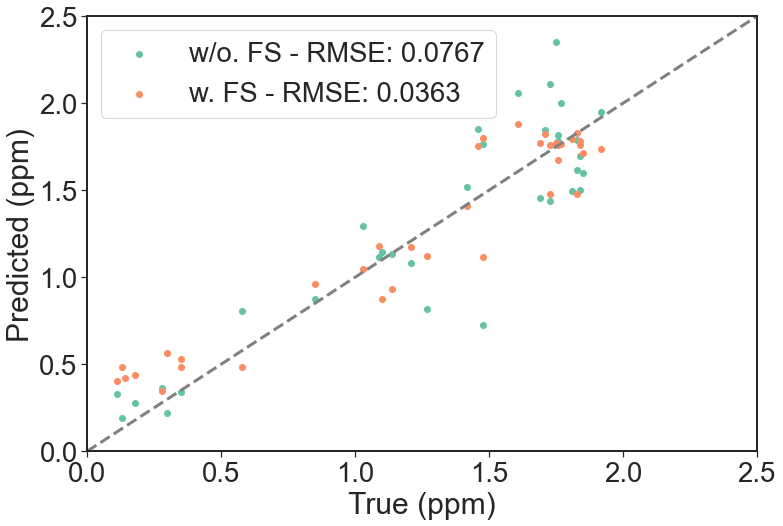

In [11]:
from sklearn import metrics


fig, ax = plt.subplots()

# without feature selection
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
ax.scatter(y_test, y_pred, label=f"w/o. FS - RMSE: {metrics.mean_squared_error(y_test, y_pred):.3}")

# with feature selection
rfe.fit(x_train, y_train)
y_pred = rfe.predict(x_test)
ax.scatter(y_test, y_pred, label=f"w. FS - RMSE: {metrics.mean_squared_error(y_test, y_pred):.3}")
ax.plot([0, 2.5], [0, 2.5], linestyle="--", c="grey")

ax.set_xlim(0, 2.5)
ax.set_ylim(0, 2.5)
ax.set_xlabel("True (ppm)")
ax.set_ylabel("Predicted (ppm)")
ax.legend()

plt.show()

## Now it's your turn!
The following code appends the data from `conditions.csv` and naïvely removes the `nan`s, but does nothing more. See if the info from `conditions.csv` provides a better estimate. Maybe another model does a better job than the linear regression? What about interpretability? etc. etc.

In [24]:
X_w_conditions = np.hstack((X, conditions))
print(f"Old amount of features ({X.shape[1]}) + features from `conditions.csv` ({conditions.shape[1]}) = new number of features ({X_w_conditions.shape[1]})")

Old amount of features (225) + features from `conditions.csv` (4) = new number of features (229)
